<a href="https://colab.research.google.com/github/Sankytanky100/Data-Assessing/blob/main/Customer_Churn_Prediction_Using_ANN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'credit-card-customer-churn-prediction:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F869651%2F1481789%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240408%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240408T014310Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D1bb6c15e316e5dfcf1a34e59425237fdc948d18a1103eea81cc6a1023ac6624c331876abecfdab804509542aab4d922b1b8b22dbacebedd5b9a089c2b9b42dd3757c60f5f414169ab65ed01f2717e246c92cfa7be6af35c05cf42f56146667f7c7e0aa77ddeec228eeeca6705eb42fd7125f8d9304c12818551cbcefdc72bf2ea00f3c92bb758ef938962e40964e2c6292b4c5500357b6c943a1932f83bab27ffd19e2a862f7de1e4a62dd7085314beaeb5577a4dddb3d9fdd3f4468a6b0a705c85e4ca1ae825ee4837a1c3a617608a123479533b22388224adfce17a026c36b086b03031eb8789bbad48bb32c820b3a43baf87a4c0dc8f0a4abf5f8ca4c2426'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 267794 bytes downloaded
Downloaded and uncompressed: credit-card-customer-churn-prediction
Data source import complete.


In [2]:
import numpy as np
import pandas as pd


import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv


In [3]:
df = pd.read_csv('/kaggle/input/credit-card-customer-churn-prediction/Churn_Modelling.csv')

In [4]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [5]:
df.drop(columns = ['RowNumber','CustomerId','Surname'],inplace=True)

In [6]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [7]:
df['Geography'].value_counts()

Geography
France     5014
Germany    2509
Spain      2477
Name: count, dtype: int64

In [8]:
df['Gender'].value_counts()

Gender
Male      5457
Female    4543
Name: count, dtype: int64

In [9]:
df = pd.get_dummies(df,columns=['Geography','Gender'],drop_first=True)

In [10]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,False,False,False
1,608,41,1,83807.86,1,0,1,112542.58,0,False,True,False
2,502,42,8,159660.80,3,1,0,113931.57,1,False,False,False
3,699,39,1,0.00,2,0,0,93826.63,0,False,False,False
4,850,43,2,125510.82,1,1,1,79084.10,0,False,True,False


In [11]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense

In [12]:

from sklearn.preprocessing import OneHotEncoder

X = df.drop(columns=['Exited'])
y = df['Exited'].values

from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=0)

# Cast y_train to float32
y_train = tf.cast(y_train, tf.float32)
'''
# One-hot encode y_train
encoder = OneHotEncoder(sparse=False)
y_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))
'''



'\n# One-hot encode y_train\nencoder = OneHotEncoder(sparse=False)\ny_train_encoded = encoder.fit_transform(y_train.reshape(-1, 1))\n'

In [13]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

X_train_trf = scaler.fit_transform(X_train)
X_test_trf = scaler.transform(X_test)



In [14]:
model = Sequential()

model.add(Dense(11,activation='sigmoid',input_dim=11))
model.add(Dense(11,activation='sigmoid'))
model.add(Dense(1,activation='sigmoid'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 11)                132       
                                                                 
 dense_1 (Dense)             (None, 11)                132       
                                                                 
 dense_2 (Dense)             (None, 1)                 12        
                                                                 
Total params: 276 (1.08 KB)
Trainable params: 276 (1.08 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [16]:
model.compile(optimizer='Adam',loss='binary_crossentropy',metrics=['accuracy'])

In [17]:
# Train the model
history = model.fit(X_train_trf, y_train, batch_size=50, epochs=100, verbose=1, validation_split=0.2)

Epoch 1/100
128/128 [==============================] - 8s 11ms/step - loss: 0.5331 - accuracy: 0.7958 - val_loss: 0.4962 - val_accuracy: 0.7969
Epoch 2/100
128/128 [==============================] - 1s 10ms/step - loss: 0.4921 - accuracy: 0.7958 - val_loss: 0.4844 - val_accuracy: 0.7969
Epoch 3/100
128/128 [==============================] - 1s 10ms/step - loss: 0.4795 - accuracy: 0.7958 - val_loss: 0.4723 - val_accuracy: 0.7969
Epoch 4/100
128/128 [==============================] - 1s 10ms/step - loss: 0.4665 - accuracy: 0.7958 - val_loss: 0.4606 - val_accuracy: 0.7969
Epoch 5/100
128/128 [==============================] - 1s 9ms/step - loss: 0.4546 - accuracy: 0.7958 - val_loss: 0.4506 - val_accuracy: 0.7969
Epoch 6/100
128/128 [==============================] - 2s 12ms/step - loss: 0.4448 - accuracy: 0.7958 - val_loss: 0.4430 - val_accuracy: 0.7969
Epoch 7/100
128/128 [==============================] - 2s 13ms/step - loss: 0.4370 - accuracy: 0.8008 - val_loss: 0.4378 - val_accuracy: 

In [18]:
y_pred = model.predict(X_test_trf)

63/63 [==============================] - 0s 3ms/step


In [19]:
y_pred

array([[0.30919665],
       [0.25525862],
       [0.1122864 ],
       ...,
       [0.13060516],
       [0.11083654],
       [0.2657495 ]], dtype=float32)

In [20]:
y_pred = y_pred.argmax(axis=-1)

In [21]:
from sklearn.metrics import accuracy_score
accuracy_score(y_test,y_pred)

0.7975

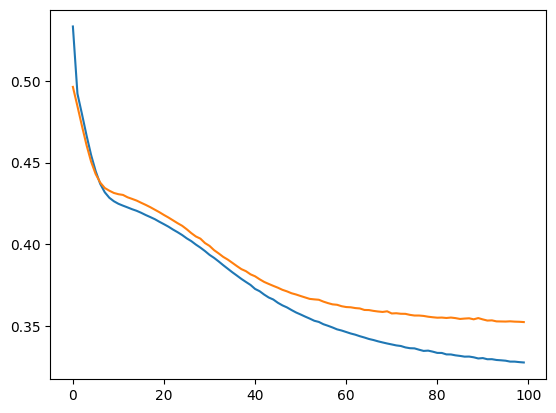

In [22]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

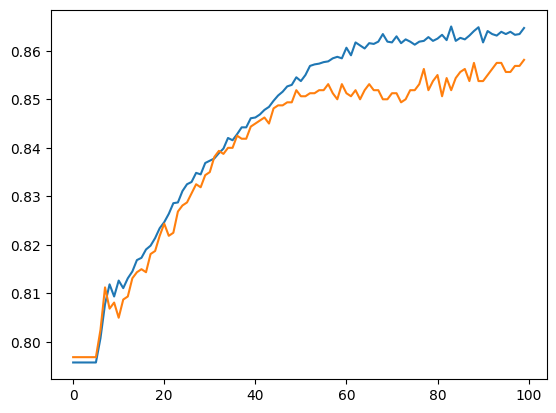

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])